<a href="https://colab.research.google.com/github/pedrorfig/mooring-prediction/blob/main/Previs%C3%A3o_de_Atracabilidade_(SMOTE).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Descrição do Projeto

---

Desenvolvimento de na construção de modelo estatístico para previsão de condições atracabilidade de navios nas monobóias do Terminal de Osório (TEDUT).

## Importação de Bibliotecas



In [ ]:
import matplotlib.pyplot as plt
import pandas as pd, numpy as np, seaborn as sns, plotly.express as px
from datetime import datetime
from google.colab import files
from datetime import datetime
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Definição de formatação para a construção de gráficos para análise.

In [ ]:
font = {'weight' : 'bold',
        'size'   : 20}
plt.rc('font', **font)
sns.set_theme(style = 'whitegrid', font_scale = 1.5 )

## Importação e leitura dos Dados do SIME, SISCOPE e iFix


Importação e leitura de dados a utilizados para a análise:


*   SIME - Sistema de Informação de Movimentações e Estadias - registra eventos de atracações de navios a partir de 09/2020. Para atualizações de dados extraídos do SIME, ver o código [Mau Tempo TEDUT.ipynb](https://colab.research.google.com/drive/1HdaLHnxHdtckKZVgaeFFrs2EWqyiq-ZU?usp=sharing)
*   SISCOPE (NM601 e NM602) - Análogo ao SIME,e já descontinuado, porém com dados anteriores a 09/2020.
*   iFix - Dados operacionais obtidos através de sensoreamento, como amplitude de deslocamento das monobóias no eixo z (Heave), velocidade de vento, deslocamento angular nos eixos y (pitch) e x (roll).

In [ ]:
#Lê dados e substitui , por .
df_iFix =  pd.read_csv("/content/drive/MyDrive/Atracabilidade TEDUT/Dados_iFix_2.csv",sep=';').stack().str.replace(',','.').unstack() # dados iFix convertendo , para .
df_iFix.to_csv("/content/drive/MyDrive/Atracabilidade TEDUT/Dados_iFix_ponto_2.csv",sep=';') #novo csv de dados iFix

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
"""

# dados do SISCOPE para a monoboia 1

df_NM601 = pd.read_csv("/content/drive/MyDrive/Atracabilidade TEDUT/MN_601.csv",\
                       sep=';',na_values=["None"], parse_dates=[["Data", "Hora"]],\
                       dayfirst=True, index_col=["Data_Hora"], dtype = {"Navio Mau Tempo":str,\
             "Status Mau Tempo":int, "Navio Operacao":str, "Status Operacao":int}) 

# dados do SISCOPE para a monoboia 2
df_NM602 = pd.read_csv("/content/drive/MyDrive/Atracabilidade TEDUT/MN_602.csv",\
                       sep=';',na_values=["None"], parse_dates=[["Data", "Hora"]],\
                       dayfirst=True, index_col=["Data_Hora"], dtype = {"Navio Mau Tempo":str,\
             "Status Mau Tempo":int, "Navio Operacao":str, "Status Operacao":int})

"""
df_iFix= pd.read_csv("/content/drive/MyDrive/Atracabilidade TEDUT/Dados_iFix_ponto_2.csv",sep=';', na_values=["None"])

df_SIME = pd.read_csv("/content/drive/MyDrive/Atracabilidade TEDUT/class_tempo_SIME_2.csv", \
                      dtype={"Espera 601":"str","Espera 602":"str","Atracado 601":"str",
                             "Atracado 602":"str", "tempo":"int32"}, index_col = ["dt"],\
                      parse_dates=True, dayfirst = True,  usecols = \
                      ["dt",'Espera 601','Espera 602','Atracado 601','Atracado 602'])

In [ ]:
df_iFix

,Unnamed: 0,Date,Time,DUT1:FAROL_UT02101_VEL_NOS.F_CV,DUT1:MN602_MRU_HEAVE.F_CV,DUT1:MN602_MRU_PITCH.F_CV,DUT1:MN602_MRU_ROLL.F_CV,DUT1:MN602_WND_SM.F_CV,DUT1:MN602_WND_SM_NOS.F_CV
0,0,02/08/2021,9:55:0,13.51566,0.101,-0.77,-1.27,NaN,NaN
1,1,02/08/2021,9:55:10,12.15972,0.101,1.83,-0.91,NaN,NaN
2,2,02/08/2021,9:55:20,11.76606,0.372,0.90,-2.29,NaN,NaN
3,3,02/08/2021,9:55:30,11.76606,-0.084,-0.81,-1.43,NaN,NaN
4,4,02/08/2021,9:55:40,11.76606,0.148,0.72,0.70,NaN,NaN
...,...,...,...,...,...,...,...,...,...
959995,959995,09/02/2022,23:47:30,16.62120,0.287,0.97,-1.44,7.547838,14.67300
959996,959996,09/02/2022,23:47:40,14.47794,0.287,0.62,-0.30,6.627705,12.88426
959997,959997,09/02/2022,23:47:50,14.47794,0.287,0.32,0.71,8.300425,16.13602
959998,959998,09/02/2022,23:48:0,14.04054,-0.056,0.14,0.71,8.138371,15.82099


In [ ]:
df_SIME

,Espera 601,Espera 602,Atracado 601,Atracado 602
dt,,,,
2020-10-01 19:06:00,STAR OSPREY,NaN,NaN,NaN
2020-10-01 19:06:10,STAR OSPREY,NaN,NaN,NaN
2020-10-01 19:06:20,STAR OSPREY,NaN,NaN,NaN
2020-10-01 19:06:30,STAR OSPREY,NaN,NaN,NaN
2020-10-01 19:06:40,STAR OSPREY,NaN,NaN,NaN
...,...,...,...,...
2022-02-10 07:23:20,NaN,NaN,NaN,SALSA
2022-02-10 07:23:30,NaN,NaN,NaN,SALSA
2022-02-10 07:23:40,NaN,NaN,NaN,SALSA


##Manipulação de Dados do SISCOPE e iFix  

In [ ]:
#Manipulando dados do iFix
df_iFix.rename(columns =\
               {'Date':'Data','Time':'Hora','DUT1:FAROL_UT02101_VEL_NOS.F_CV':'Vento Farol',
                'DUT1:MN602_MRU_HEAVE.F_CV': 'HEAVE','DUT1:MN602_MRU_PITCH.F_CV':'PITCH',
                'DUT1:MN602_MRU_ROLL.F_CV':'ROLL'},inplace = True)
df_iFix = df_iFix[["Data", "Hora", "Vento Farol", "HEAVE", "PITCH", "ROLL"]]
df_iFix["dt"] = pd.to_datetime(df_iFix["Data"]+" "+df_iFix["Hora"],format="%d/%m/%Y %H:%M:%S", dayfirst=True) 
#df_iFix["dt"] = pd.to_datetime(df_iFix["Data"]+" "+df_iFix["Hora"],format="%d/%m/%Y %H:%M:%S", errors='coerce',dayfirst=True) 
df_iFix.drop(["Data","Hora"],inplace=True,axis=1)
df_iFix = df_iFix.drop_duplicates(subset=['dt'])
df_iFix.set_index("dt",drop=True,inplace=True, verify_integrity=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
# Manipulando dados do SISCOPE

#Rearranjo de dados
df_NM601.rename(columns ={'Navio Mau Tempo': 'Espera 601',
                          'Status Mau Tempo': 'Cond Tempo 601',
                          'Navio Operacao': 'Atracado 601'}, inplace = True)
df_NM601 = df_NM601[['Cond Tempo 601','Espera 601', 'Atracado 601']]
df_NM601.index.name = "dt"
df_NM602.rename(columns ={'Navio Mau Tempo':'Espera 602',
                          'Status Mau Tempo':'Cond Tempo 602',
                          'Navio Operacao':'Atracado 602'}, inplace = True)
df_NM602 = df_NM602[['Cond Tempo 602','Espera 602', 'Atracado 602']]
df_NM602.index.name = "dt"
#Merge dados MN
df_MN = df_NM601.join(df_NM602)[['Espera 601','Atracado 601',
                                 'Espera 602', 'Atracado 602']]
#Determinando o tipo dados de cada coluna
df_MN.astype({"Espera 601":"str","Espera 602":"str",
              "Atracado 601":"str","Atracado 602":"str"})
df_MN

NameError: ignored

## Unindo a dados do SIME

In [ ]:
#Concat de dados do SISCOPE, SIME e iFIX
#df_All = pd.concat([df_MN, df_SIME], verify_integrity=True)
df_All = df_SIME
df_All = df_All.join(df_iFix)


In [ ]:
df_iFix['HEAVE']==0

dt
2020-01-10 19:06:00     True
2020-01-10 19:06:10     True
2020-01-10 19:06:20     True
2020-01-10 19:06:30     True
2020-01-10 19:06:40     True
                       ...  
2022-02-10 07:23:20    False
2022-02-10 07:23:30    False
2022-02-10 07:23:40    False
2022-02-10 07:23:50    False
2022-02-10 07:24:00    False
Name: HEAVE, Length: 3809429, dtype: bool

In [ ]:
df_All = df_All[df_All["HEAVE"]!=0]

In [ ]:
df_All.sample(100)

,Espera 601,Espera 602,Atracado 601,Atracado 602,Vento Farol,HEAVE,PITCH,ROLL
dt,,,,,,,,
2021-08-27 02:06:40,SKS DARENT,NaN,NaN,NaN,2.4057,-0.669,-0.2,-2.12
2021-12-28 16:08:40,NaN,NaN,TRENT,NaN,NaN,NaN,NaN,NaN
2020-11-12 18:40:00,NaN,NaN,AQUANUS,ELKA LEBLON,NaN,NaN,NaN,NaN
2021-07-06 22:25:30,NaN,NaN,ZOUZOU,NaN,NaN,NaN,NaN,NaN
2021-10-27 09:47:10,NaN,NaN,NaN,EAGLE PASSOS,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2020-11-12 01:11:30,NaN,NaN,SEAWAYS GUAYAQUIL,JOSE DO PATROCINIO,NaN,NaN,NaN,NaN
2020-11-12 08:19:00,NaN,NaN,SEAWAYS GUAYAQUIL,JOSE DO PATROCINIO,NaN,NaN,NaN,NaN
2021-04-28 21:40:50,NaN,NaN,NaN,EAGLE PAULINIA,NaN,NaN,NaN,NaN


In [ ]:
df_All

,Espera 601,Espera 602,Atracado 601,Atracado 602,Vento Farol,HEAVE,PITCH,ROLL
dt,,,,,,,,
2020-10-01 19:06:00,STAR OSPREY,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-01 19:06:10,STAR OSPREY,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-01 19:06:20,STAR OSPREY,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-01 19:06:30,STAR OSPREY,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-01 19:06:40,STAR OSPREY,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2022-02-10 07:23:20,NaN,NaN,NaN,SALSA,NaN,NaN,NaN,NaN
2022-02-10 07:23:30,NaN,NaN,NaN,SALSA,NaN,NaN,NaN,NaN
2022-02-10 07:23:40,NaN,NaN,NaN,SALSA,NaN,NaN,NaN,NaN


##Reagrupando os dados em intervalos de 10 minutos


*   A agregação de valores de Heave se deu calculando a diferença entre máximo e mínimo do intervalo adotado
*   A agregação de valores de  velocidade do vento se deu calculando a média dos 5 maiores valores.



In [ ]:
#Excluindo dados que não contenham informações de sensoreamento
df_All = df_All[df_All["HEAVE"].notna()]

In [ ]:
df_All.sample(50)

,Espera 601,Espera 602,Atracado 601,Atracado 602,Vento Farol,HEAVE,PITCH,ROLL
dt,,,,,,,,
2022-01-12 21:07:20,NaN,NaN,NaN,HORIZON ARMONIA,14.12802,-0.099,-0.22,0.96
2021-09-22 21:54:20,NaN,OCEAN PHOENIX,NaN,NaN,21.56382,0.107,0.10,-1.24
2021-08-10 17:48:00,HORIZON APHRODITE,NaN,NaN,NaN,11.67858,0.032,0.40,-0.77
2021-09-13 10:04:50,CELSIUS EVERETT,RIO GRANDE,NaN,NaN,12.07224,0.498,0.78,-0.04
2021-11-14 18:12:10,NAVIGARE PACTOR,NaN,NaN,NaN,25.58790,0.035,0.27,0.06
2022-01-15 23:00:00,NaN,NaN,NaN,NAVE RIGEL,7.04214,-0.075,0.57,-1.52
2022-01-11 14:45:40,NaN,NaN,NaN,SAO LUIZ,11.06622,0.129,-0.93,-1.37
2021-11-20 16:02:30,NaN,NaN,NaN,RS TARA,18.63324,0.176,-1.31,0.72
2022-02-09 20:12:40,NaN,NaN,NaN,SALSA,12.42216,0.118,-0.01,0.15


In [ ]:
#Checando os maiores valores de vento

def highlight_max(s):
    # Obter os 5 maiores valores de uma coluna
    is_large = s.nlargest(5).values
    # Aplica o realce caso o valor esteja entre os 5 maiores
    return ['background-color: yellow' if v in is_large else '' for v in s]

df_All[['Vento Farol', 'HEAVE']].head(60).\
style.highlight_max(subset=["HEAVE"])\
.highlight_max(subset=["Vento Farol"])

,Vento Farol,HEAVE
dt,,
2021-08-04 17:30:00,7.916940,0.197000
2021-08-04 17:30:10,8.048160,-0.123000
2021-08-04 17:30:20,8.048160,0.139000
2021-08-04 17:30:30,8.529300,-0.213000
2021-08-04 17:30:40,8.529300,0.328000
2021-08-04 17:30:50,8.748000,0.328000
2021-08-04 17:31:00,8.748000,-0.101000
2021-08-04 17:31:10,8.748000,-0.101000
2021-08-04 17:31:20,8.748000,-0.363000


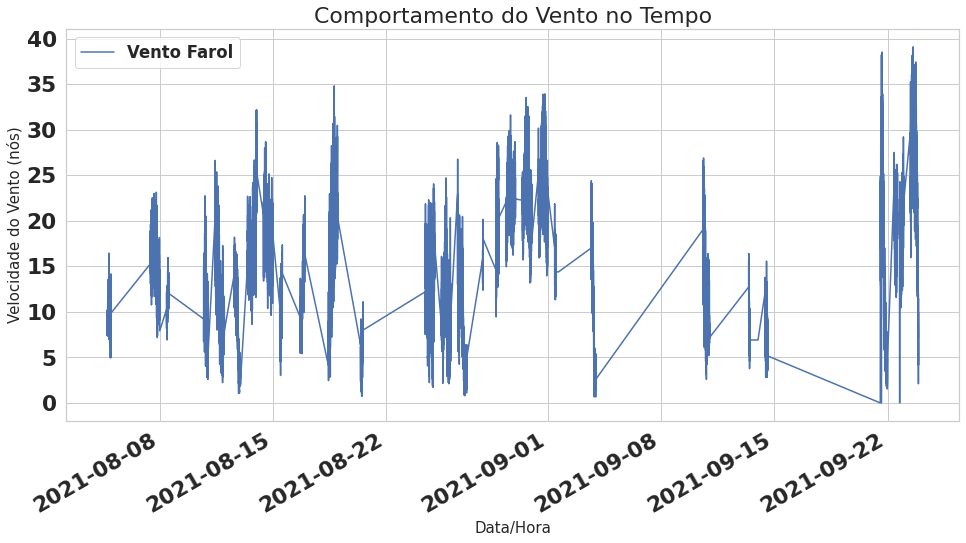

In [ ]:
df_All[['Vento Farol']].head(100000).plot(figsize = (16,8))
plt.title("Comportamento do Vento no Tempo", size = 22)
plt.xlabel("Data/Hora", size = 15)
plt.tick_params(axis = 'both', labelsize = 'large' )
plt.ylabel("Velocidade do Vento (nós)", size = 15)
plt.show()

Reamostragem de valores de heave, pitch e roll para a diferença entre valores máximos e mínimos em um intervalo de 10 min. Para dados de vento, fez-se a média dos 5 maiores valores de vento em um intervalo de 10 min.

Quando for retreinar, descomentar a célula abaixo.

In [ ]:
## Para dados de heave, pitch e roll, calcula-se a diferença de valóres máximos e mínimos para intervalos de 10 minutos.
## Para valores de vento, calcula-se a média dos 5 maiores valores em um intervalo de 10 minutos.


df_iFix_Sig = pd.DataFrame(columns = ['diff_mean_Heave','mean_Wind_Max'], \
                            index=df_All.resample("10T").first().index)

df_iFix_Sig['diff_mean_Heave'] =df_All.resample("10T")["HEAVE"].max()-df_All.resample("10T")["HEAVE"].min()
df_iFix_Sig['diff_mean_Pitch'] =df_All.resample("10T")["PITCH"].max()-df_All.resample("10T")["PITCH"].min()
df_iFix_Sig['diff_mean_Roll'] =df_All.resample("10T")["ROLL"].max()-df_All.resample("10T")["ROLL"].min()
df_iFix_Sig['mean_Wind_Max'] = df_All.resample("10T")["Vento Farol"].nlargest(5).groupby(level = 0).mean()

df_iFix_Sig.to_csv( "/content/drive/MyDrive/Atracabilidade TEDUT/df_iFix_Sig_all_2.csv", index=True, encoding='utf-8-sig')
df_iFix_Sig

,diff_mean_Heave,mean_Wind_Max,diff_mean_Pitch,diff_mean_Roll
dt,,,,
2021-08-02 09:50:00,0.941,15.571440,2.87,4.63
2021-08-02 10:00:00,0.760,13.778100,3.86,5.53
2021-08-02 10:10:00,0.808,11.984760,3.39,6.42
2021-08-02 10:20:00,0.811,15.877620,2.75,6.36
2021-08-02 10:30:00,0.818,14.959080,4.42,7.04
...,...,...,...,...
2022-02-09 23:00:00,1.162,20.356596,3.97,4.01
2022-02-09 23:10:00,0.986,21.957480,3.11,3.14
2022-02-09 23:20:00,1.121,17.977140,2.62,3.35


In [ ]:
df_iFix_Sig = pd.read_csv(r"/content/drive/MyDrive/Atracabilidade TEDUT/df_iFix_Sig_all_2.csv",sep=',', index_col="dt", parse_dates=True) #dados new wave

In [ ]:
col_mono = list(df_iFix_Sig.columns)
col_mono

['diff_mean_Heave', 'mean_Wind_Max', 'diff_mean_Pitch', 'diff_mean_Roll']

Eliminação de dados de falhas do sensoreamento

In [ ]:
df_iFix_Sig=df_iFix_Sig.loc[df_iFix_Sig['diff_mean_Heave']>= 0.01]

Unindo dados de ondas significativas com dados de SISCOPE e SIME

In [ ]:
df_sig = df_iFix_Sig.join(df_All[["Espera 601","Atracado 601","Espera 602","Atracado 602"]], sort=True)

In [ ]:
df_sig

,diff_mean_Heave,mean_Wind_Max,diff_mean_Pitch,diff_mean_Roll,Espera 601,Atracado 601,Espera 602,Atracado 602
dt,,,,,,,,
2021-08-02 09:50:00,0.941,15.571440,2.87,4.63,NaN,NaN,NaN,NaN
2021-08-02 10:00:00,0.760,13.778100,3.86,5.53,NaN,ROMULO ALMEIDA,NaN,NaN
2021-08-02 10:10:00,0.808,11.984760,3.39,6.42,NaN,ROMULO ALMEIDA,NaN,NaN
2021-08-02 10:20:00,0.811,15.877620,2.75,6.36,NaN,ROMULO ALMEIDA,NaN,NaN
2021-08-02 10:30:00,0.818,14.959080,4.42,7.04,NaN,ROMULO ALMEIDA,NaN,DAN SABIA
...,...,...,...,...,...,...,...,...
2022-02-09 23:00:00,1.162,20.356596,3.97,4.01,NaN,NaN,NaN,SALSA
2022-02-09 23:10:00,0.986,21.957480,3.11,3.14,NaN,NaN,NaN,SALSA
2022-02-09 23:20:00,1.121,17.977140,2.62,3.35,NaN,NaN,NaN,SALSA


#Estabelecendo uma classificação de condição de tempo


*   Classificação de bom tempo - Será considerado bom tempo um intervalo de +-90min (considerar apenas -, pois heave muda na atração) dado que houve uma atracação em qualquer uma das monobóias
*   Classificação de mau tempo - Agrupamento em **40 min ** de momentos onde há espera por mau tempo e nenhum navio atracado a uma monobóia.



In [ ]:

condicoes = [
             ((df_sig["Atracado 601"].isna() & (df_sig["Atracado 601"].shift(-1)).notna())| \
              (df_sig["Atracado 602"].isna() & (df_sig["Atracado 602"].shift(-1)).notna())),
              ((df_sig["Espera 601"].notna() & df_sig["Atracado 601"].isna())| \
               (df_sig["Espera 602"].notna() & df_sig["Atracado 602"].isna()))
              ]

valores = ["Bom Tempo", "Mau Tempo"]

df_sig["tempo"] = np.select(condlist=condicoes, choicelist=valores, default = "Indeterminado")

In [ ]:
df_sig.loc["23-01-2022"].between_time("19:20", "21:00").resample("40T").ffill()
# .replace( {"tempo": {1 : "Mau Tempo", 2 : "-"}})

,diff_mean_Heave,mean_Wind_Max,diff_mean_Pitch,diff_mean_Roll,Espera 601,Atracado 601,Espera 602,Atracado 602,tempo
dt,,,,,,,,,
2022-01-23 19:20:00,0.724,5.42376,2.99,3.22,NaN,NaN,AMAZON VICTORY,AMAZON VICTORY,Indeterminado
2022-01-23 20:00:00,1.092,8.00442,3.05,3.66,NaN,NaN,AMAZON VICTORY,AMAZON VICTORY,Indeterminado
2022-01-23 20:40:00,1.070,5.99238,3.13,4.00,NaN,NaN,AMAZON VICTORY,AMAZON VICTORY,Indeterminado


In [ ]:
df_sig.loc["03-18-2021"].between_time("09:40","10:00")
# .replace( {"tempo": [0, 2]},"Bom Tempo")

,diff_mean_Heave,mean_Wind_Max,diff_mean_Pitch,diff_mean_Roll,Espera 601,Atracado 601,Espera 602,Atracado 602,tempo
dt,,,,,,,,,
2021-03-18 09:40:00,1.100,16.92738,3.66,4.36,NaN,NaN,NaN,NaN,Bom Tempo
2021-03-18 09:50:00,1.027,18.72072,3.67,6.28,NaN,NaN,NaN,RECIFE KNUTSEN,Indeterminado
2021-03-18 10:00:00,0.758,19.63926,12.45,12.54,NaN,NaN,NaN,RECIFE KNUTSEN,Indeterminado


In [ ]:
# Somente dados de bom e mau tempo serão utilizados para a construção do modelo
# Verificações das condições são realizadas apenas entre 6 e 17h, esperas em outros horários não serão consideradas. 
df_inter_sig = df_sig.between_time("06:00", "17:00")

In [ ]:
df_inter_sig.loc["03-18-2021"].head(10)

KeyError: ignored

## Manipulando dados de bom tempo

In [ ]:
# Definindo sub df para diferentes condições de tempo
df_inter_sig_Bom = df_inter_sig.loc[df_inter_sig['tempo'] == "Bom Tempo"] # data frame final tempo bom

# Adicionando uma coluna id à dataframe
df_inter_sig_Bom.reset_index(inplace = True)
df_inter_sig_Bom["id"] = df_inter_sig_Bom.index
df_inter_sig_Bom.set_index("dt", inplace = True)

# Reamostrando dados de bom tempo para um intervalo de +- 90 min, a partir do momento de atracação.
index_men1 = df_inter_sig_Bom.index.shift(-1, freq="90T")
nindex = (df_inter_sig_Bom.index).append(index_men1).drop_duplicates()

df_inter_sig_Bom = df_inter_sig_Bom.reindex(index=nindex,method="bfill").sort_index()

index_mai1 = df_inter_sig_Bom.index.shift(1, freq="90T")
nindex = (df_inter_sig_Bom.index).append(index_mai1).drop_duplicates()

df_inter_sig_Bom = df_inter_sig_Bom.reindex(index=nindex,method="ffill").sort_index()

df_inter_sig_Bom = df_inter_sig_Bom[["id", "tempo"]].groupby("id").resample("10T").ffill().reset_index(level = 0, drop = True)
df_inter_sig_Bom = df_inter_sig_Bom.join(df_inter_sig.loc[:,df_inter_sig.columns != "tempo"])
df_inter_sig_Bom.pop("id")

df_inter_sig_Bom

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,tempo,diff_mean_Heave,mean_Wind_Max,diff_mean_Pitch,diff_mean_Roll,Espera 601,Atracado 601,Espera 602,Atracado 602
dt,,,,,,,,,
2021-08-02 08:20:00,Bom Tempo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-02 08:30:00,Bom Tempo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-02 08:40:00,Bom Tempo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-02 08:50:00,Bom Tempo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-02 09:00:00,Bom Tempo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2022-02-09 10:40:00,Bom Tempo,1.159,14.39046,3.16,2.92,NaN,NaN,NaN,SALSA
2022-02-09 10:50:00,Bom Tempo,1.458,13.55940,4.00,3.21,NaN,NaN,NaN,SALSA
2022-02-09 11:00:00,Bom Tempo,1.124,13.55940,3.56,3.93,NaN,NaN,NaN,SALSA


In [ ]:
# Definindo sub df para diferentes condições de tempo
df_inter_sig_Mau = df_inter_sig.loc[df_inter_sig['tempo'] == "Mau Tempo"] # data frame final tempo bom
df_inter_sig_Mau

,diff_mean_Heave,mean_Wind_Max,diff_mean_Pitch,diff_mean_Roll,Espera 601,Atracado 601,Espera 602,Atracado 602,tempo
dt,,,,,,,,,
2021-08-07 10:00:00,1.151,18.72072,3.98,4.80,BW PETREL,NaN,SAO LUIZ,NaN,Mau Tempo
2021-08-07 10:10:00,0.953,19.63926,3.87,5.49,BW PETREL,NaN,SAO LUIZ,NaN,Mau Tempo
2021-08-07 10:20:00,0.842,18.37080,4.46,4.90,BW PETREL,NaN,SAO LUIZ,NaN,Mau Tempo
2021-08-07 10:30:00,1.424,20.12040,4.45,5.03,BW PETREL,NaN,SAO LUIZ,NaN,Mau Tempo
2021-08-07 10:40:00,1.198,18.80820,5.27,4.44,BW PETREL,NaN,SAO LUIZ,NaN,Mau Tempo
...,...,...,...,...,...,...,...,...,...
2022-02-08 16:20:00,1.406,23.83830,2.79,4.33,NaN,NaN,SALSA,NaN,Mau Tempo
2022-02-08 16:30:00,1.182,20.64528,2.80,3.81,NaN,NaN,SALSA,NaN,Mau Tempo
2022-02-08 16:40:00,1.216,23.09472,2.49,3.18,NaN,NaN,SALSA,NaN,Mau Tempo


In [ ]:
## Reamostragem não utilizada, pois a técnica de SMOTE será utilizada para o balanceamento do número de classificações de bom e mau tempo

#df_inter_sig_Mau = df_inter_sig_Mau.resample("40T").mean()
df_inter_sig_Mau.drop_duplicates(subset=df_inter_sig_Mau.columns, keep="first", inplace=True)
df_inter_sig_Mau

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,diff_mean_Heave,mean_Wind_Max,diff_mean_Pitch,diff_mean_Roll,Espera 601,Atracado 601,Espera 602,Atracado 602,tempo
dt,,,,,,,,,
2021-08-07 10:00:00,1.151,18.72072,3.98,4.80,BW PETREL,NaN,SAO LUIZ,NaN,Mau Tempo
2021-08-07 10:10:00,0.953,19.63926,3.87,5.49,BW PETREL,NaN,SAO LUIZ,NaN,Mau Tempo
2021-08-07 10:20:00,0.842,18.37080,4.46,4.90,BW PETREL,NaN,SAO LUIZ,NaN,Mau Tempo
2021-08-07 10:30:00,1.424,20.12040,4.45,5.03,BW PETREL,NaN,SAO LUIZ,NaN,Mau Tempo
2021-08-07 10:40:00,1.198,18.80820,5.27,4.44,BW PETREL,NaN,SAO LUIZ,NaN,Mau Tempo
...,...,...,...,...,...,...,...,...,...
2022-02-08 16:20:00,1.406,23.83830,2.79,4.33,NaN,NaN,SALSA,NaN,Mau Tempo
2022-02-08 16:30:00,1.182,20.64528,2.80,3.81,NaN,NaN,SALSA,NaN,Mau Tempo
2022-02-08 16:40:00,1.216,23.09472,2.49,3.18,NaN,NaN,SALSA,NaN,Mau Tempo


In [ ]:
df_inter_sig = pd.concat([df_inter_sig_Bom,df_inter_sig_Mau])
nindex = df_inter_sig.index.duplicated(keep="first")
df_inter_sig = df_inter_sig[~nindex].sort_index()

In [ ]:
df_inter_sig[df_inter_sig['tempo'] =='Mau Tempo']

,tempo,diff_mean_Heave,mean_Wind_Max,diff_mean_Pitch,diff_mean_Roll,Espera 601,Atracado 601,Espera 602,Atracado 602
dt,,,,,,,,,
2021-08-07 10:00:00,Mau Tempo,1.151,18.72072,3.98,4.80,BW PETREL,NaN,SAO LUIZ,NaN
2021-08-07 10:10:00,Mau Tempo,0.953,19.63926,3.87,5.49,BW PETREL,NaN,SAO LUIZ,NaN
2021-08-07 10:20:00,Mau Tempo,0.842,18.37080,4.46,4.90,BW PETREL,NaN,SAO LUIZ,NaN
2021-08-07 10:30:00,Mau Tempo,1.424,20.12040,4.45,5.03,BW PETREL,NaN,SAO LUIZ,NaN
2021-08-07 10:40:00,Mau Tempo,1.198,18.80820,5.27,4.44,BW PETREL,NaN,SAO LUIZ,NaN
...,...,...,...,...,...,...,...,...,...
2022-02-08 16:20:00,Mau Tempo,1.406,23.83830,2.79,4.33,NaN,NaN,SALSA,NaN
2022-02-08 16:30:00,Mau Tempo,1.182,20.64528,2.80,3.81,NaN,NaN,SALSA,NaN
2022-02-08 16:40:00,Mau Tempo,1.216,23.09472,2.49,3.18,NaN,NaN,SALSA,NaN


In [ ]:
# Pitch e Roll removidos
# Se houver alguma linha com diff_mean_Heave ou mean_Wind_Max nulos, será excluída do data frame.

df_inter_sig = df_inter_sig[df_inter_sig[["diff_mean_Heave","mean_Wind_Max"]].notnull().any(axis=1)]

In [ ]:
#Medindo os desbalanceamento do conjuntos de dados, para o treinamento do modelo de classificação, SMOTE será aplicado.
df_inter_sig.query("tempo == 'Bom Tempo'").shape[0], df_inter_sig.query("tempo == 'Mau Tempo'").shape[0]

(1060, 2338)

#Análise dos Dados

In [ ]:
df_inter_sig.loc["03-07-2020"]

KeyError: ignored

In [ ]:
df_All.loc["03-03-2020"].between_time("08:01", "08:10").style.hide_columns(["Espera 601","Atracado 601","Espera 602","Atracado 602", "PITCH", "ROLL"])

,Vento Farol,HEAVE
dt,,
2020-03-03 08:01:00,13.515660,0.209000
2020-03-03 08:01:10,13.515660,0.209000
2020-03-03 08:01:20,13.515660,-0.306000
2020-03-03 08:01:30,13.515660,-0.306000
2020-03-03 08:01:40,13.515660,-0.423000
2020-03-03 08:01:50,13.515660,0.262000
2020-03-03 08:02:00,11.766060,-0.701000
2020-03-03 08:02:10,10.278900,0.486000
2020-03-03 08:02:20,10.016460,1.104000


In [ ]:
# df_inter_sig["03-03-2021"].style.highlight_max(subset = ["diff_mean_Heave","mean_Wind_Max"], color = "red").highlight_min(subset = ["diff_mean_Heave","mean_Wind_Max"], color = "lightgreen")
# cm = sns.light_palette("coolwarm", as_cmap=True)
# df_inter_sig["03-02-2021"].style.background_gradient(cmap=cm)
df_inter_sig[col_mono].loc["03-03-2020"].rename(columns = {"diff_mean_Heave":"Delta Heave","mean_Wind_Max":"Média do Vento" }).style.background_gradient("coolwarm")

KeyError: ignored

In [ ]:
#Coleção de dias quando o mean_Wind_Max teve indicação abaixo de 5 nós e, ainda sim, houve indicação de mau tempo.

dates = set(df_inter_sig.query("tempo == 'Mau Tempo'").index.strftime("%d/%m/%y"))&set(df_inter_sig.query("mean_Wind_Max < 5").index.strftime("%d/%m/%y"))
np.asarray(list(dates))

array(['22/08/20', '13/05/20', '12/09/20', '07/06/20', '28/08/20',
       '17/07/20', '21/09/20', '15/09/20', '01/01/20', '27/02/20',
       '18/06/20', '08/10/20', '29/03/20', '25/02/20', '10/07/20',
       '21/03/20', '26/02/20', '17/08/20', '05/10/20', '26/11/20',
       '17/01/21', '01/08/20', '09/03/20', '22/09/20', '14/04/20',
       '13/03/21', '08/07/20', '30/07/20', '13/03/20', '11/04/20',
       '27/07/20', '29/05/20', '23/02/20', '25/01/20', '02/10/20',
       '08/05/20', '24/02/21', '19/06/20', '12/04/20', '10/05/20',
       '04/09/20', '15/02/20', '19/01/21', '20/10/20', '06/04/20',
       '20/09/20', '13/07/20'], dtype='<U8')

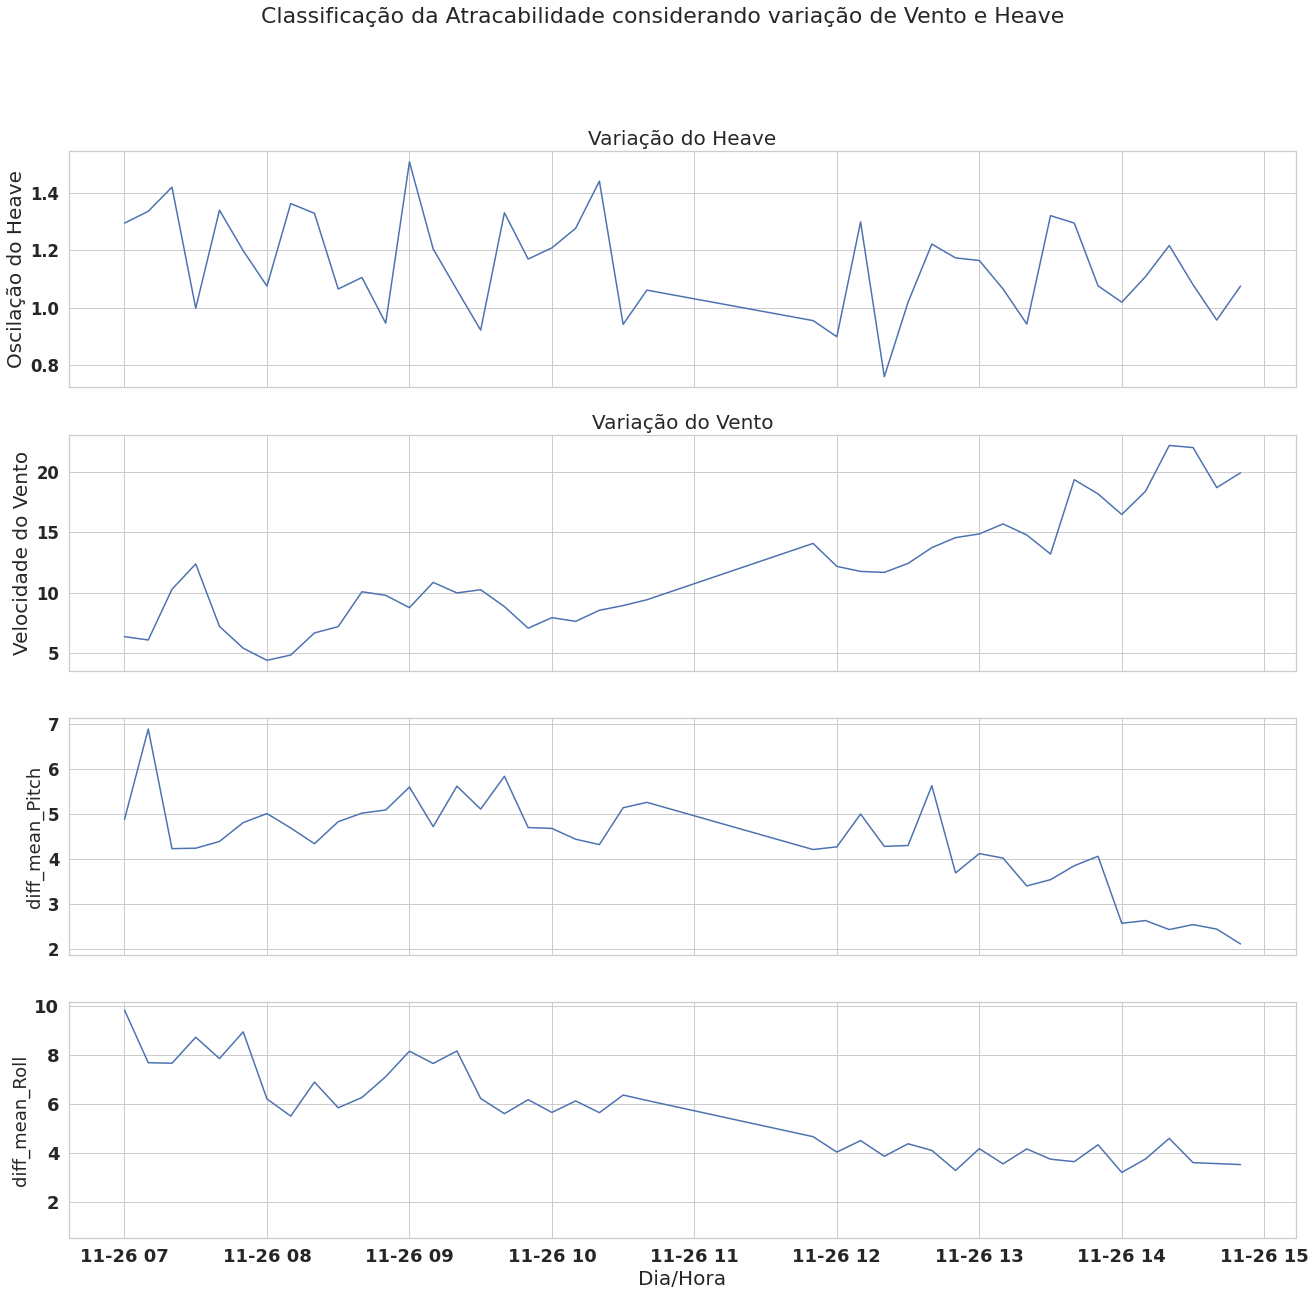

In [ ]:
df_g1 = df_inter_sig.loc['26/11/20'].between_time("07:00","18:30")
fig, ax = plt.subplots(4,1,figsize=(22,20),sharex=True)
fig.suptitle("Classificação da Atracabilidade considerando variação de Vento e Heave", fontsize = 22)
for i,col in enumerate(col_mono):
  sns.lineplot(ax = ax[i],y = col,x = df_g1.index,data=df_g1)
  ax[i].fill_between(x = df_g1.index, y1 = col, where = df_g1["tempo"]==1,data=df_g1, color = "red" , alpha = 0.3)
# ax[1].fill_between(x = df_g1.index, y1 = "mean_Wind_Max", where = df_g1["tempo"]==1,data=df_g1, color = "red" , alpha = 0.3)
ax[0].set_title("Variação do Heave", fontsize = 20)
ax[0].set_ylabel("Oscilação do Heave", fontsize = 20)
ax[1].set_title("Variação do Vento", fontsize = 20)
ax[1].set_ylabel("Velocidade do Vento", fontsize = 20)
plt.tick_params(axis = 'both', labelsize = 'medium')
plt.ylim(0.5)
plt.xlabel("Dia/Hora", size = 20)
plt.show()

In [ ]:
#Contagem de dias de mau tempo, a cada mês.

df_g2 = df_inter_sig_Mau[["tempo"]].groupby(by=[df_inter_sig_Mau.index.year, df_inter_sig_Mau.index.month,df_inter_sig_Mau.index.day]).max()
df_g2.index.rename(["Ano", "Mês", "dia"], inplace=True)
df_g2.rename(columns={"tempo":"Dias de Mau Tempo"}, inplace=True)
df_g2.groupby(level=[0,1]).count()

Dias de Mau Tempo
Ano  Mês                   
2020 1                   13
     2                   20
     3                   18
     4                   12
     5                   11
     6                   14
     7                   18
     8                   17
     9                   15
     10                  12
     11                   6
     12                  10
2021 1                   19
     2                    2
     3                   13

Análise descritiva de todos os dados

In [ ]:
X = df_inter_sig[col_mono]

In [ ]:
X.describe()

,diff_mean_Heave,mean_Wind_Max,diff_mean_Pitch,diff_mean_Roll
count,12418.000000,12418.000000,12418.000000,12418.000000
mean,1.242933,18.324764,4.619402,4.862349
std,0.383932,7.765421,1.474531,1.498819
min,0.171000,1.390932,0.770000,1.020000
25%,0.977000,12.546819,3.600000,3.810000
50%,1.196000,18.152100,4.470000,4.680000
75%,1.456000,23.663340,5.430000,5.680000
max,3.316000,58.874040,15.380000,14.860000


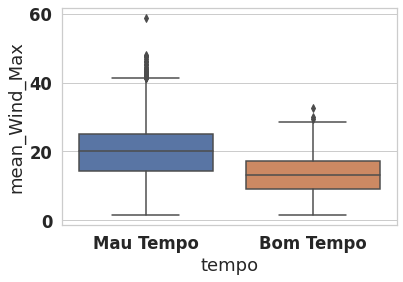

In [ ]:
ax = sns.boxplot(x = "tempo", y = "mean_Wind_Max",data= df_inter_sig)
plt.show()

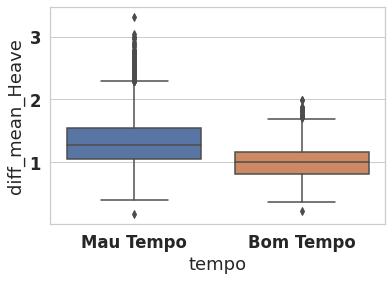

In [ ]:
ax = sns.boxplot(x = "tempo", y = "diff_mean_Heave",data= df_inter_sig)
plt.show()

Análise da frequência de todos os atributos

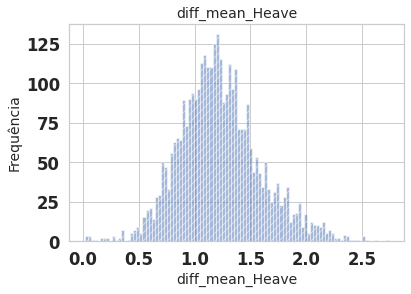

A média do diff_mean_Heave é  1.2229802825191292
O desvio padrão do diff_mean_Heave é  0.3626190801871205
O max do diff_mean_Heave é 2.739
O min do diff_mean_Heave é 0.0179999999999999


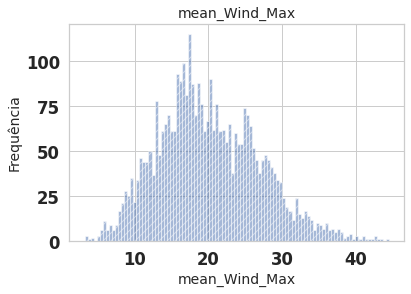

A média do mean_Wind_Max é  20.066841026486102
O desvio padrão do mean_Wind_Max é  6.868116380548847
O max do mean_Wind_Max é 44.52732
O min do mean_Wind_Max é 3.14928


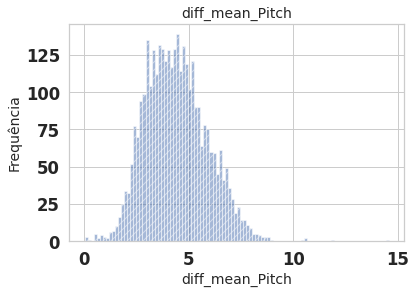

A média do diff_mean_Pitch é  4.39550912301354
O desvio padrão do diff_mean_Pitch é  1.4640917681207237
O max do diff_mean_Pitch é 14.57
O min do diff_mean_Pitch é 0.03


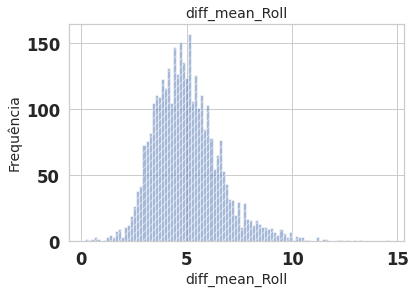

A média do diff_mean_Roll é  4.994590935844617
O desvio padrão do diff_mean_Roll é  1.5909062295973435
O max do diff_mean_Roll é 14.6
O min do diff_mean_Roll é 0.1600000000000001


In [ ]:
for col in col_mono:
  df_inter_sig[col].plot.hist(bins=100, alpha=0.5, hatch = '///')
  plt.title(f"{col}", fontsize=14)
  plt.xlabel(f"{col}", fontsize=14)
  plt.ylabel('Frequência', fontsize=14)
  plt.show()
  
  print(f"A média do {col} é "+" "+str(np.mean(abs(df_inter_sig[col]))))
  print(f"O desvio padrão do {col} é "+" "+str(np.std(abs(df_inter_sig[col]))))
  print(f"O max do {col} é {str(np.max((df_inter_sig[col])))}")
  print(f"O min do {col} é {str(np.min((df_inter_sig[col])))}")

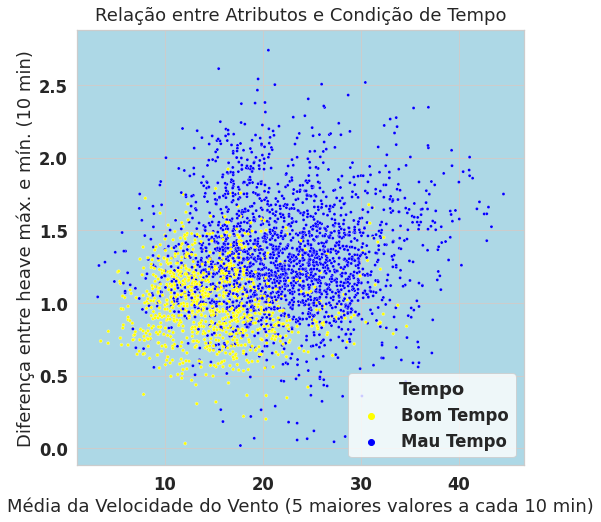

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(8,8),sharex=True)
ax.set_facecolor('lightblue')
sns.scatterplot(y = 'diff_mean_Heave', x = 'mean_Wind_Max',hue = "tempo", palette= ['yellow', 'blue'], s = 10, data=df_inter_sig)
plt.xlabel('Média da Velocidade do Vento (5 maiores valores a cada 10 min)')
plt.ylabel('Diferença entre heave máx. e mín. (10 min)')
plt.title("Relação entre Atributos e Condição de Tempo", pad = 10)
plt.legend(title="Tempo")
plt.show()

A média do diff_mean_Heave para BOM tempo é  1.0138764150943396
O desvio padrão do diff_mean_Heave para BOM tempo é  0.2579480216954229
O max do diff_mean_Heave para BOM tempo é  1.92
O min do diff_mean_Heave para BOM tempo é  0.032


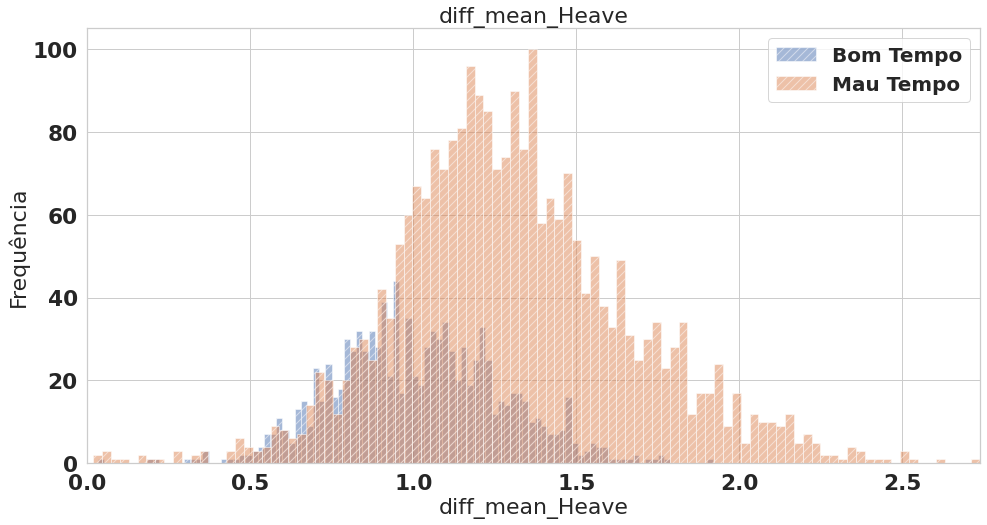

A média do diff_mean_Heave para MAU tempo é  1.3055753758634716
O desvio padrão do diff_mean_Heave para MAU tempo é  0.36301944904525213
O max do diff_mean_Heave para MAU tempo é  2.739
O min do diff_mean_Heave para MAU tempo é  0.0179999999999999
A média do mean_Wind_Max para BOM tempo é  15.554150320754717
O desvio padrão do mean_Wind_Max para BOM tempo é  5.24402190143308
O max do mean_Wind_Max para BOM tempo é  34.64208
O min do mean_Wind_Max para BOM tempo é  3.45546


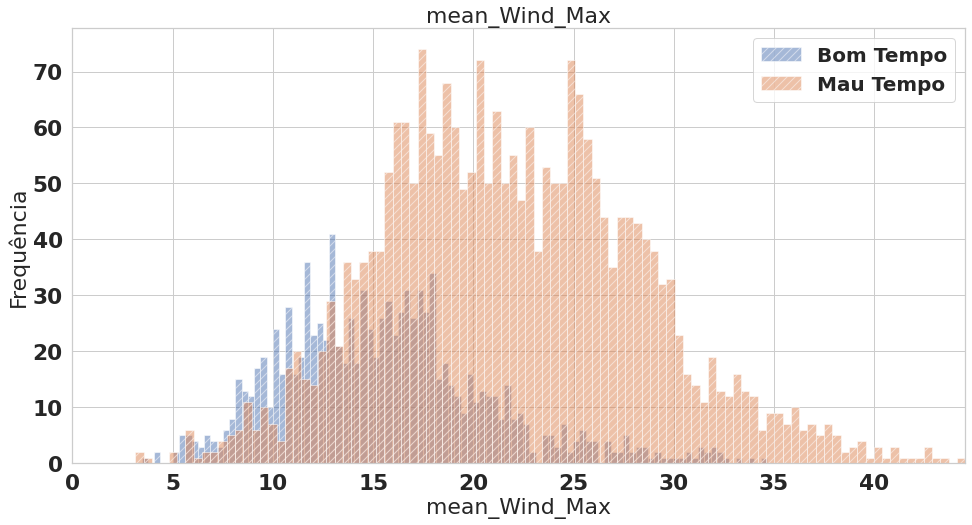

A média do mean_Wind_Max para MAU tempo é  21.928445597724483
O desvio padrão do mean_Wind_Max para MAU tempo é  6.525213192759932
O max do mean_Wind_Max para MAU tempo é  44.52732
O min do mean_Wind_Max para MAU tempo é  3.14928
A média do diff_mean_Pitch para BOM tempo é  3.6298207547169787
O desvio padrão do diff_mean_Pitch para BOM tempo é  1.117644282164963
O max do diff_mean_Pitch para BOM tempo é  11.81
O min do diff_mean_Pitch para BOM tempo é  0.68


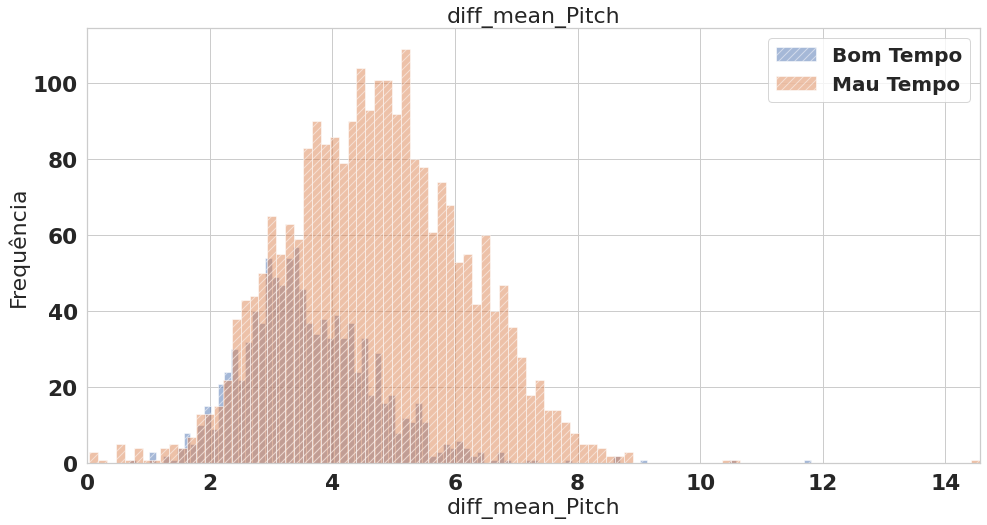

A média do diff_mean_Pitch para MAU tempo é  4.708256806176358
O desvio padrão do diff_mean_Pitch para MAU tempo é  1.456014390032431
O max do diff_mean_Pitch para MAU tempo é  14.57
O min do diff_mean_Pitch para MAU tempo é  0.03
A média do diff_mean_Roll para BOM tempo é  4.18640566037736
O desvio padrão do diff_mean_Roll para BOM tempo é  1.2676949091202785
O max do diff_mean_Roll para BOM tempo é  12.66
O min do diff_mean_Roll para BOM tempo é  0.1600000000000001


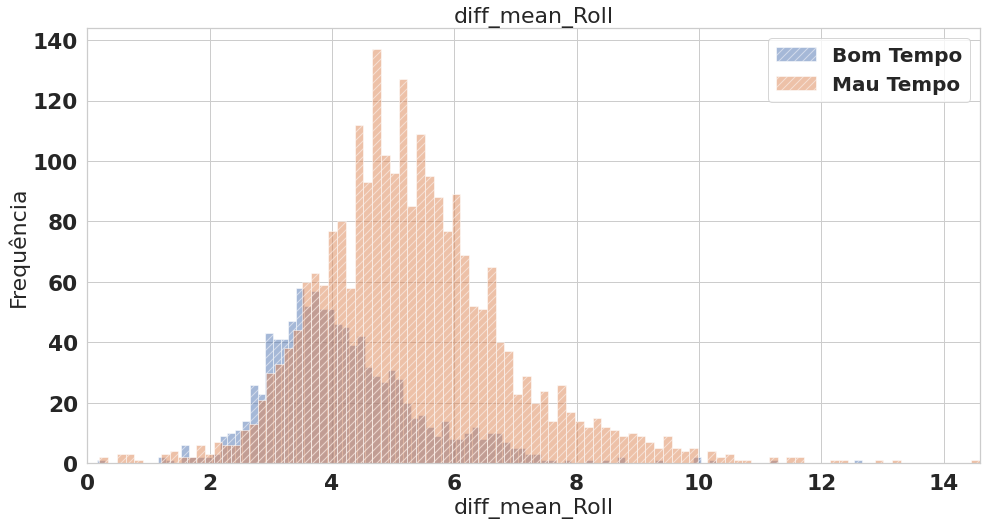

A média do diff_mean_Roll para MAU tempo é  5.305481511580654
O desvio padrão do diff_mean_Roll para MAU tempo é  1.5839707220902675
O max do diff_mean_Roll para MAU tempo é  14.6
O min do diff_mean_Roll para MAU tempo é  0.1899999999999999


In [ ]:
 for col in col_mono:
  # Bom tempo
  df_inter_sig_Bom[col].plot.hist(bins=100, alpha=0.5, hatch = '///', figsize=(16,8))
  plt.title(f"{col}", fontsize=22)
  plt.xlim([0,np.max((df_inter_sig_Mau[col]))])
  plt.xlabel(f"{col}", fontsize=14)
  plt.ylabel('Frequência de Ocorrência', fontsize=14)

  print(f"A média do {col} para BOM tempo é "+" "+str(np.mean(abs(df_inter_sig_Bom[col]))))
  print(f"O desvio padrão do {col} para BOM tempo é "+" "+str(np.std(abs(df_inter_sig_Bom[col]))))
  print(f"O max do {col} para BOM tempo é "+" "+str(np.max((df_inter_sig_Bom[col]))))
  print(f"O min do {col} para BOM tempo é "+" "+str(np.min((df_inter_sig_Bom[col]))))

  # Mau tempo
  df_inter_sig_Mau[col].plot.hist(bins=100, alpha=0.5, hatch = '///')
  plt.xlabel(f"{col}", fontsize=22)
  plt.ylabel('Frequência', fontsize=22)
  plt.xlim([0,np.max(df_inter_sig_Mau[col])])
  plt.tick_params(axis = 'both', labelsize = 'large' )
  plt.legend(["Bom Tempo", "Mau Tempo"], fontsize = 20)
  plt.show()
  print(f"A média do {col} para MAU tempo é "+" "+str(np.mean(abs(df_inter_sig_Mau[col]))))
  print(f"O desvio padrão do {col} para MAU tempo é "+" "+str(np.std(abs(df_inter_sig_Mau[col]))))
  print(f"O max do {col} para MAU tempo é "+" "+str(np.max((df_inter_sig_Mau[col]))))
  print(f"O min do {col} para MAU tempo é "+" "+str(np.min((df_inter_sig_Mau[col]))))

In [ ]:
df_inter_sig.to_csv("/content/drive/MyDrive/Atracabilidade TEDUT/Dados_Loy_2.csv")

In [ ]:
df_inter_sig=pd.read_csv("/content/drive/MyDrive/Atracabilidade TEDUT/Dados_Loy_2.csv",sep=',')

In [ ]:
df_inter_sig

,Unnamed: 0,dt,tempo,diff_mean_Heave,mean_Wind_Max,diff_mean_Pitch,diff_mean_Roll,Espera 601,Atracado 601,Espera 602,Atracado 602
0,0,2021-08-02 09:50:00,Bom Tempo,0.941,15.57144,2.87,4.63,NaN,NaN,NaN,NaN
1,1,2021-08-02 10:20:00,Bom Tempo,0.811,15.87762,2.75,6.36,NaN,ROMULO ALMEIDA,NaN,NaN
2,2,2021-08-02 10:30:00,Bom Tempo,0.818,14.95908,4.42,7.04,NaN,ROMULO ALMEIDA,NaN,DAN SABIA
3,3,2021-08-02 10:40:00,Bom Tempo,0.843,14.56542,4.28,6.37,NaN,ROMULO ALMEIDA,NaN,DAN SABIA
4,4,2021-08-02 10:50:00,Bom Tempo,0.841,13.73436,5.21,6.48,NaN,ROMULO ALMEIDA,NaN,DAN SABIA
...,...,...,...,...,...,...,...,...,...,...,...
3393,3393,2022-02-09 10:40:00,Bom Tempo,1.159,14.39046,3.16,2.92,NaN,NaN,NaN,SALSA
3394,3394,2022-02-09 10:50:00,Bom Tempo,1.458,13.55940,4.00,3.21,NaN,NaN,NaN,SALSA
3395,3395,2022-02-09 11:00:00,Bom Tempo,1.124,13.55940,3.56,3.93,NaN,NaN,NaN,SALSA
3396,3396,2022-02-09 11:10:00,Bom Tempo,1.146,13.12200,2.89,3.98,NaN,NaN,NaN,SALSA


# Aplicando um modelo de classificação

In [ ]:
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
import matplotlib.patches as mpatches

In [ ]:
# Apenas as colunas de Heave e Vento serão utilizadas para realizar a previsão,
# já que pitch e roll não indicaram ter influência sobre as condições de atracabilidade.
col_mono[0:2]

NameError: ignored

In [ ]:
X = df_inter_sig.loc[:,col_mono[0:2]]
y = df_inter_sig.loc[:,'tempo'].ravel()

In [ ]:
print(f'Original dataset shape {Counter(y)}')

Original dataset shape Counter({'Mau Tempo': 2338, 'Bom Tempo': 1060})


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y)

pipeline = imbpipeline(steps = [['smote', SMOTE()],
                                ['scaler', StandardScaler()],
                                ['classifier', KNeighborsClassifier(n_neighbors=13)]])

# param_grid = {'classifier__n_neighbors':np.arange(5,31)}
# stratified_kfold = StratifiedShuffleSplit(n_splits=5, test_size= 0.3)
# knn_gs = GridSearchCV(estimator = pipeline, param_grid = param_grid, scoring="accuracy", cv = stratified_kfold)
# knn_gs.fit(X_train, y_train)
# cv_score = knn_gs.best_score_

pipeline.fit(X_train, y_train)

Pipeline(steps=[('smote', SMOTE()), ('scaler', StandardScaler()),
                ['classifier', KNeighborsClassifier(n_neighbors=13)]])

Salvando o Modelo final

In [ ]:
pipe_sav = 'pipeline_atracabilidade_2.sav'
pickle.dump(pipeline, open(pipe_sav, 'wb'))

Avaliando o Modelo



In [ ]:
test_score = pipeline.score(X_test, y_test)
test_score

0.7519607843137255

In [ ]:
y_hat = pipeline.predict(X_test)
y_hat_prob = pipeline.predict_proba(X_test)

In [ ]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

   Bom Tempo       0.58      0.74      0.65       318
   Mau Tempo       0.87      0.76      0.81       702

    accuracy                           0.75      1020
   macro avg       0.72      0.75      0.73      1020
weighted avg       0.78      0.75      0.76      1020



In [ ]:
# Medição da performance do modelo para probablidades acima de 80%
y_prob = pd.DataFrame(y_hat_prob, columns=["Bom Tempo", "Mau Tempo"])
nindex = y_prob[y_prob.max(axis=1)>=0.8].index

In [ ]:
X_test_2 = X_test.iloc[nindex]
y_test_2 = y_test[nindex]
test_score_2 = pipeline.score(X_test_2, y_test_2)
test_score_2

0.8361486486486487

In [ ]:
y_hat_2 = pipeline.predict(X_test_2)
print(classification_report(y_test_2, y_hat_2))

              precision    recall  f1-score   support

   Bom Tempo       0.67      0.77      0.72       161
   Mau Tempo       0.91      0.86      0.88       431

    accuracy                           0.84       592
   macro avg       0.79      0.82      0.80       592
weighted avg       0.85      0.84      0.84       592



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


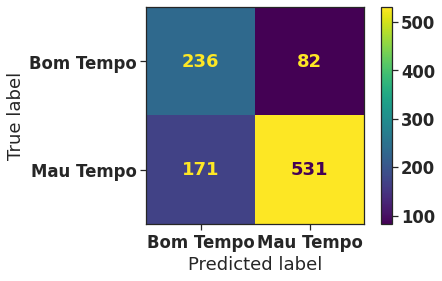

In [ ]:
with sns.axes_style('ticks', rc={'font':{'size':10}}):
  plot_confusion_matrix(pipeline,X_test, y_test, values_format="d")
  plt.show()

In [ ]:
y_pred = pipeline.predict(X_test)
y_pred

array(['Mau Tempo', 'Bom Tempo', 'Bom Tempo', ..., 'Mau Tempo',
       'Bom Tempo', 'Mau Tempo'], dtype=object)

In [ ]:
X_train[['diff_mean_Heave']]

,diff_mean_Heave
dt,
2021-08-03 10:30:00,0.674
2021-08-24 14:20:00,1.442
2021-08-16 16:20:00,1.083
2021-09-23 13:10:00,1.619
2021-12-01 16:40:00,1.316
...,...
2021-08-28 09:50:00,1.281
2021-12-30 11:50:00,0.876
2021-08-27 12:50:00,1.305


In [ ]:
X_train.iloc[:,0]

dt
2020-09-10 08:50:00    1.207
2020-02-22 07:50:00    1.196
2020-11-17 08:20:00    0.956
2020-04-22 15:00:00    0.611
2020-07-08 08:00:00    2.742
                       ...  
2020-07-27 06:30:00    0.844
2020-01-05 14:10:00    1.415
2020-12-03 15:30:00    1.218
2021-03-27 08:00:00    0.702
2021-03-13 12:10:00    0.852
Name: diff_mean_Heave, Length: 8692, dtype: float64

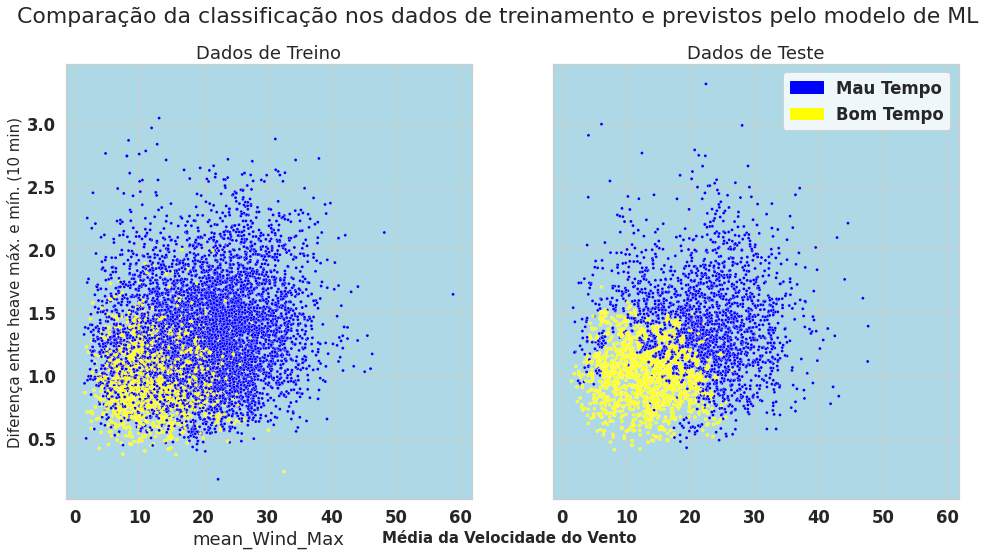

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(16,8),sharex=True,sharey=True )
fig.suptitle("Comparação da classificação nos dados de treinamento e previstos pelo modelo de ML", size = 22)
ax[0].set_facecolor('lightblue')
ax[1].set_facecolor('lightblue')

ax[0].set_ylabel('Diferença entre heave máx. e mín. (10 min)', size = 15)
sns.scatterplot(ax = ax[0], y = X_train.iloc[:,0], x = X_train.iloc[:,1],hue = y_train,  palette=['blue','yellow'], s = 10)
ax[0].get_legend().remove()
ax[0].set_title("Dados de Treino")
sns.scatterplot(ax = ax[1],y = X_test.iloc[:,0], x = X_test.iloc[:,1], hue = y_pred, palette=['blue','yellow'], s = 10).set(xlabel = None)
ax[1].set_title("Dados de Teste")

mau_tempo = mpatches.Patch(color='blue', label='Mau Tempo')
bom_tempo = mpatches.Patch(color='yellow', label='Bom Tempo')
plt.legend(handles=[mau_tempo, bom_tempo])
# plt.legend(handles = ["Mau tempo", "Bom Tempo"])

fig.text(x = 0.40, y = 0.05, s = "Média da Velocidade do Vento", size= 15)
plt.show()

#Teste com valores de 05/2021

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Atracabilidade TEDUT/heave_maio2.csv",sep=';',decimal=",", dtype = {'Date': "str",'Time':'str', 'DUT1:FAROL_UT02101_VEL_NOS.F_CV': 'float64', 'DUT1:MN602_MRU_HEAVE.F_CV': 'float64','DUT1:MN602_MRU_PITCH.F_CV':'float64', 'DUT1:MN602_MRU_ROLL.F_CV':'float64'} )
df.rename(columns ={'Date': 'Data','Time':'Hora', 'DUT1:FAROL_UT02101_VEL_NOS.F_CV': 'Vento Farol', 'DUT1:MN602_MRU_HEAVE.F_CV': 'HEAVE','DUT1:MN602_MRU_PITCH.F_CV':'PITCH', 'DUT1:MN602_MRU_ROLL.F_CV':'ROLL'},inplace = True)
df = df[["Data", "Hora", "Vento Farol", "HEAVE", "PITCH", "ROLL"]]
df["dt"] = pd.to_datetime(df["Data"]+" "+df["Hora"], format="%d/%m/%Y %H:%M:%S", dayfirst=True) 
df.drop(["Data", "Hora"], inplace=True, axis=1)
df.set_index("dt", drop=True, inplace=True, verify_integrity=True)
df

In [ ]:
df_Sig = pd.DataFrame(columns = ['diff_mean_Heave','mean_Wind_Max'], \
                           index=df.resample("10T").first().index)
df_Sig['diff_mean_Heave'] =df.resample("10T")["HEAVE"].max()-df.resample("10T")["HEAVE"].min()
df_Sig['mean_Wind_Max'] = df.resample("10T")["Vento Farol"].nlargest(5).groupby(level = 0).mean()
df_Sig
df_inter_sig = df_sig.between_time("06:00", "17:00")

In [ ]:
X = df_Sig[['diff_mean_Heave', 'mean_Wind_Max']]
y_prev = pipeline.predict(X)

In [ ]:
df_Sig["Tempo_prev"] = y_prev
df_Sig["25-05-2021"].between_time("10:00","17:00").head(60)

#Teste de Mudança de Comportamento em Atracações

In [ ]:
pd.read_excel("/content/drive/MyDrive/Atracabilidade TEDUT/estadias_osório.xlsx")

,Berço,Início Atracação,Término Desatracação,Nome Embarcação
0,602,2021-12-16 18:00:00,2021-12-17 12:54:00,FRONT BRAGE
1,601,2021-12-15 19:36:00,2021-12-16 18:06:00,POLAR ACE
2,602,2021-12-15 14:00:00,2021-12-16 15:25:00,SAO SEBASTIAO
3,601,2021-12-13 13:12:00,2021-12-14 18:30:00,PILTENE
4,602,2021-12-12 17:06:00,2021-12-14 06:18:00,ELKA PARANA
...,...,...,...,...
199,601,2020-10-08 08:55:00,2020-10-10 03:35:00,CELSO FURTADO
200,601,2020-10-06 09:06:00,2020-10-07 17:36:00,SPOTTAIL
201,602,2020-10-01 08:25:00,2020-10-01 18:55:00,NAVION STAVANGER
202,601,2020-09-30 13:06:00,2020-10-01 19:48:00,JO PINARI


In [ ]:
#Contagem de dias de mau tempo, a cada mês.

df_g2 = df_inter_sig_Mau[["tempo"]].groupby(by=[df_inter_sig_Mau.index.year, df_inter_sig_Mau.index.month,df_inter_sig_Mau.index.day]).max()
df_g2.index.rename(["Ano", "Mês", "dia"], inplace=True)
df_g2.rename(columns={"tempo":"Dias de Mau Tempo"}, inplace=True)
df_g2.groupby(level=[0,1]).count()